In [1]:
#Importando módulos necessários
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision import models
from torchsummary import summary
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from datetime import date

In [2]:
#Importando implementação da arquitetura da rede Pix2Pix
import Pix2Pix_Model as model

In [3]:
#definindo device de acordo com a disponibilidade
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
print(torch.cuda.get_device_name(device))

cuda
GeForce GTX 1050


In [4]:
#initialize D, G
D = model.PatchGAN_Discriminator(7).to(device)
D.apply(model._initialize_weights)

G = model.UnetGenerator(6).to(device)
G.apply(model._initialize_weights)

print('Modelos Inicializados')

Modelos Inicializados


In [5]:
#optimizers
optimizerD = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5,0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5,0.999))

#Loss Functions
criterionD = nn.BCELoss()
criterionG = nn.L1Loss()

In [7]:
path_checkpoint_load = 'checkpoints_model/8000_lambda=1500_L2_images_satelite_2.tar'

import os
#Checando se o arquivo existe
if os.path.isfile(path_checkpoint_load):
    print("\nCarregando checkpoint de " + path_checkpoint_load)
    #Carregando informações salvas do modelo
    checkpoint = torch.load(path_checkpoint_load)
    epoch_ini = checkpoint['epoch']
    
    G.load_state_dict(checkpoint['Generator_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
    lossG = checkpoint['loss_G']

    D.load_state_dict(checkpoint['Discriminator_state_dict'])
    optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
    lossD = checkpoint['loss_D']
    
    print("\nCarregado: '{}' \n Epoch: {} \n LossG: {} \n LossD: {}".format(path_checkpoint_load, epoch_ini, lossG, lossD))
    
else:
    print("Arquivo não encontrado !")



Carregando checkpoint de checkpoints_model/8000_lambda=1500_L2_images_satelite_2.tar

Carregado: 'checkpoints_model/8000_lambda=1500_L2_images_satelite_2.tar' 
 Epoch: 200 
 LossG: 31.681446075439453 
 LossD: 1.4865036064293236e-05


In [97]:
batch_size = 1

dataloader_A = model.load_dataset(batch_size,'ChangeDetectionDataset/Real/subset/test/A/',False)

dataloader_B = model.load_dataset(batch_size,'ChangeDetectionDataset/Real/subset/test/B/',False)

dataloader_OUT = model.load_dataset(batch_size,'ChangeDetectionDataset/Real/subset/test/OUT/',True)

In [98]:
def show_imgs(x, new_fig=True):
    grid = torchvision.utils.make_grid(x.detach().cpu())
    #The detach() method constructs a new view on a tensor which is declared not to need 
    #gradients, i.e., it is to be excluded from further tracking of operations, and therefore the 
    #subgraph involving this view is not recorded.

    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.axis('off')
    plt.imshow(grid.numpy())

In [99]:
iterA = iter(dataloader_A)
iterB = iter(dataloader_B)
iterOUT= iter(dataloader_OUT)

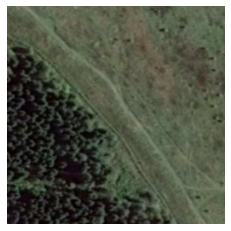

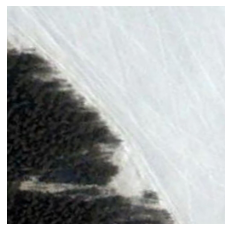

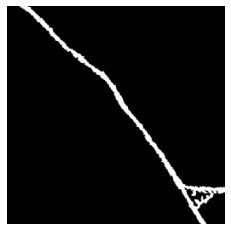

In [202]:
img_At, _ = iterA.next()
img_Bt, _ = iterB.next()
img_OUTt, _ = iterOUT.next()

img_At = img_At.to(device)
img_Bt = img_Bt.to(device)
img_OUTt = img_OUTt.to(device)

show_imgs(img_At,True)
show_imgs(img_Bt,True)
show_imgs(img_OUTt,True)

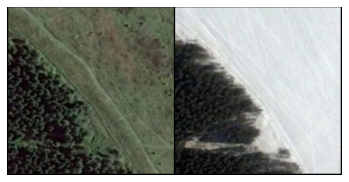

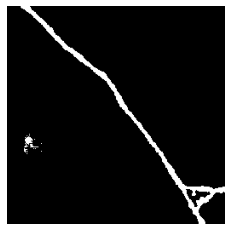

In [203]:
img_ABt = model.concatenate_torch(img_At, img_Bt)
img_ABshow = torch.cat([img_At, img_Bt], 0)
show_imgs(img_ABshow)
#generate image 
img_gent = G(img_ABt)
img_gent[ img_gent < 0.5] = 0
img_gent[ img_gent != 0] = 1
show_imgs(img_gent)